<a href="https://colab.research.google.com/github/Sdperkins04/whos_important/blob/main/final_project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DS 311 Final Project \
Spencer Perkins

In [2]:
# Importing necessary packages

import json
import numpy as np
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
# Connecting to drive

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Final_Project

Mounted at /content/drive
/content/drive/MyDrive/Final_Project


In [4]:
# Loading primary dataset from json (NOTE: file paths may need to be changed)
f = open('congress_network_data.json')
data = json.load(f)

# Inward connections for each node (followers)
inList = data[0]['inList']
# Outward connections for each node (following)
outList = data[0]['outList']
# Node username
usernameList = data[0]['usernameList']

In [5]:
# Loading supplemental data (NOTE: file paths may need to be changed)
f2 = open('supplemental_data.json')
data2 = json.load(f2)

# Node last name
lastName = data2[0]['lastName']
# Node political party
party = data2[0]['party']
# Node gender
gender = data2[0]['gender']

In [6]:
# Adding "job" variable (Senator vs Representative)
jobList = ["Sen"] * 91 + ["Rep"] * 384

In [7]:
# Creating multidirectional graph
congress = nx.MultiDiGraph()

# Adding nodes and node attributes
for i, (name, username, job, party, gender) in enumerate(zip(lastName, usernameList, jobList, party, gender)):
    congress.add_node(i, name = name, username = username, job = job, party = party, gender = gender)

# Add in outward connections
for i, connections in enumerate(outList):
    for target in connections:
        congress.add_edge(i, target, direction = 'out')

# Add inward connections
for i, connections in enumerate(inList):
    for target in connections:
        congress.add_edge(i, target, direction = 'in')

print(congress.number_of_nodes())
print(congress.number_of_edges())

475
26578


In [8]:
# Calculating Degree Centrality for directed graph, listing first few nodes

degree = nx.degree_centrality(congress)
for node in congress.nodes(data = True):
    print(f"Node {node[0]}: {node[1]}, Centrality: {degree[node[0]]}")
    if node[0] >= 4:
      break

Node 0: {'name': 'Baldwin', 'username': 'SenatorBaldwin', 'job': 'Sen', 'party': 'D', 'gender': 'F'}, Centrality: 0.1940928270042194
Node 1: {'name': 'Barrasso', 'username': 'SenJohnBarrasso', 'job': 'Sen', 'party': 'R', 'gender': 'M'}, Centrality: 0.1729957805907173
Node 2: {'name': 'Bennet', 'username': 'SenatorBennet', 'job': 'Sen', 'party': 'D', 'gender': 'M'}, Centrality: 0.23206751054852318
Node 3: {'name': 'Blackburn', 'username': 'MarshaBlackburn', 'job': 'Sen', 'party': 'R', 'gender': 'F'}, Centrality: 0.2362869198312236
Node 4: {'name': 'Blumenthal', 'username': 'SenBlumenthal', 'job': 'Sen', 'party': 'D', 'gender': 'M'}, Centrality: 0.2742616033755274


In [9]:
# Calculating Closeness Centrality for directed graph, listing first few nodes

closeness = nx.closeness_centrality(congress)
for node in congress.nodes(data = True):
    print(f"Node {node[0]}: {node[1]}, Centrality: {closeness[node[0]]}")
    if node[0] >= 4:
      break

Node 0: {'name': 'Baldwin', 'username': 'SenatorBaldwin', 'job': 'Sen', 'party': 'D', 'gender': 'F'}, Centrality: 0.4540229885057471
Node 1: {'name': 'Barrasso', 'username': 'SenJohnBarrasso', 'job': 'Sen', 'party': 'R', 'gender': 'M'}, Centrality: 0.4759036144578313
Node 2: {'name': 'Bennet', 'username': 'SenatorBennet', 'job': 'Sen', 'party': 'D', 'gender': 'M'}, Centrality: 0.4817073170731707
Node 3: {'name': 'Blackburn', 'username': 'MarshaBlackburn', 'job': 'Sen', 'party': 'R', 'gender': 'F'}, Centrality: 0.5146579804560261
Node 4: {'name': 'Blumenthal', 'username': 'SenBlumenthal', 'job': 'Sen', 'party': 'D', 'gender': 'M'}, Centrality: 0.4812182741116751


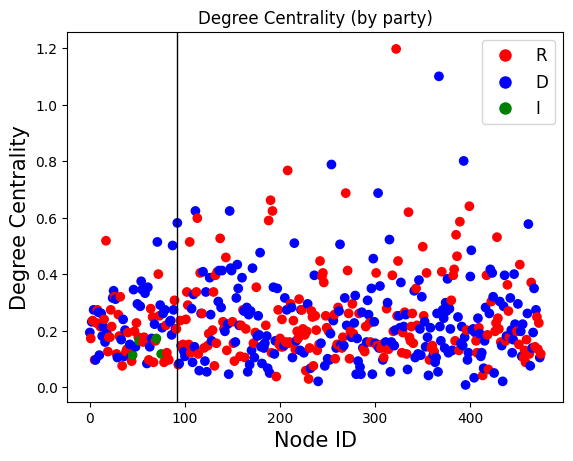

In [10]:
# Plotting Degree Centrality measures based by party

# Setting colors for each party
party_colors = {
    "R": "red",
    "D": "blue",
    "I": "green"
}

# Reformatting values to match array ID
keys = list(map(int, degree.keys()))
max_index = max(keys)
dc = np.zeros(max_index + 1)
colors = []
for k, v in degree.items():
    dc[int(k)] = v
    party = congress.nodes[int(k)]['party']
    colors.append(party_colors.get(party, "gray"))

# Plotting graph
plt.scatter(range(len(dc)), dc, c = colors, label = 'Degree Centrality')
plt.axvline(x = 91.5, color = 'black', linewidth = 1) # Adding line separating Senators (left) and Representatives (right)
plt.xlabel('Node ID', fontsize = 15)
plt.ylabel('Degree Centrality', fontsize = 15)
plt.title('Degree Centrality (by party)')

# Creating legend
legend_elements = [
    Line2D([0], [0], marker = 'o', color = 'w', label = 'R', markerfacecolor = 'red', markersize = 10),
    Line2D([0], [0], marker = 'o', color = 'w', label = 'D', markerfacecolor = 'blue', markersize = 10),
    Line2D([0], [0], marker = 'o', color = 'w', label = 'I', markerfacecolor = 'green', markersize = 10),]
plt.legend(handles = legend_elements, fontsize = 12)

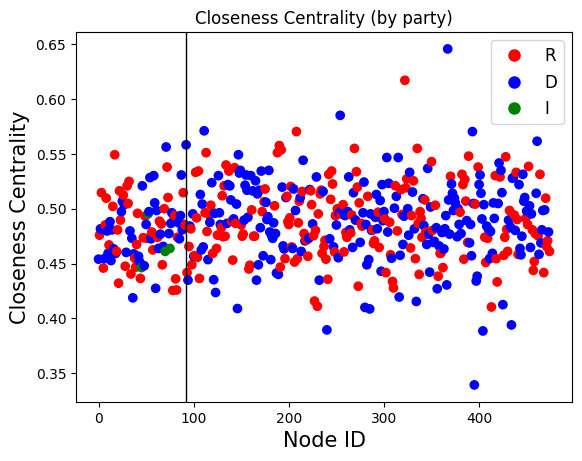

In [11]:
# Plotting Closeness Centrality measures based by party

# Setting colors for each party
party_colors = {
    "R": "red",
    "D": "blue",
    "I": "green"
}

# Reformatting values to match array ID
keys = list(map(int, closeness.keys()))
max_index = max(keys)
cc = np.zeros(max_index + 1)
colors = []
for k, v in closeness.items():
    cc[int(k)] = v
    party = congress.nodes[int(k)]['party']
    colors.append(party_colors.get(party, "gray"))

# Plotting graph
plt.scatter(range(len(cc)), cc, c = colors, label = 'Closeness Centrality')
plt.axvline(x = 91.5, color = 'black', linewidth = 1) # Adding line separating Senators (left) and Representatives (right)
plt.xlabel('Node ID', fontsize = 15)
plt.ylabel('Closeness Centrality', fontsize = 15)
plt.title('Closeness Centrality (by party)')

# Creating legend
legend_elements = [
    Line2D([0], [0], marker = 'o', color = 'w', label = 'R', markerfacecolor = 'red', markersize = 10),
    Line2D([0], [0], marker = 'o', color = 'w', label = 'D', markerfacecolor = 'blue', markersize = 10),
    Line2D([0], [0], marker = 'o', color = 'w', label = 'I', markerfacecolor = 'green', markersize = 10),]
plt.legend(handles = legend_elements, fontsize = 12)

In [12]:
# Convert graph to dataframe for modeling
nodes = list(congress.nodes)
df = pd.DataFrame({
    'node': nodes,
    'degree_centrality': [degree[n] for n in nodes],
    'closeness_centrality': [closeness[n] for n in nodes],
    'gender': [congress.nodes[n]['gender'] for n in nodes],
    'job': [congress.nodes[n]['job'] for n in nodes],
    'party': [congress.nodes[n]['party'] for n in nodes],
})

# Drop "I" (Independent) party members (data too small to be used)
df = df[df['party'].isin(['D', 'R'])].reset_index(drop = True)

# Adding variables based on difference from Centrality mean for both measures
degree_mean = df['degree_centrality'].mean()
df['degree_diff'] = df['degree_centrality'] - degree_mean
closeness_mean = df['closeness_centrality'].mean()
df['closeness_diff'] = df['closeness_centrality'] - closeness_mean

# Encoding categorical variables
job_encoder = LabelEncoder()
df['job'] = job_encoder.fit_transform(df['job'])
gender_encoder = LabelEncoder()
df['gender'] = gender_encoder.fit_transform(df['gender'])

In [13]:
# Baseline Logistic Regression model involving Degree Centrality

# Define X and y
X = df[['job', 'gender', 'degree_centrality', 'degree_diff']]
y = df['party']

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 21)

# Training the model
clf_degree = LogisticRegression()
clf_degree.fit(X_train, y_train)
y_pred = clf_degree.predict(X_test)

# Reporting results
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           D       0.78      0.41      0.54        75
           R       0.57      0.87      0.69        67

    accuracy                           0.63       142
   macro avg       0.67      0.64      0.61       142
weighted avg       0.68      0.63      0.61       142

[[31 44]
 [ 9 58]]


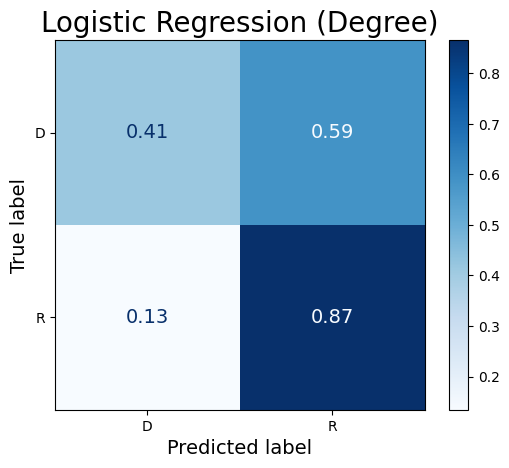

In [14]:
# Plotting confusion matrix
mat = ConfusionMatrixDisplay.from_estimator(clf_degree, X_test, y_test, cmap = 'Blues', normalize = 'true')
for text in mat.ax_.texts:
    text.set_fontsize(14)

plt.xlabel('Predicted label', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.title('Logistic Regression (Degree)', fontsize = 20)
plt.show()

In [15]:
# SVM model with Degree Centrality

# Using GridSearch to tune the SVM; training model
param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01],'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
grid_degree = GridSearchCV(svm.SVC(probability=True), param_grid, refit = True)
grid_degree.fit(X_train, y_train)
y_pred = grid_degree.predict(X_test)

# Reporting results
print(f"Best Parameters: {grid_degree.best_estimator_}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Best Parameters: SVC(C=1, gamma=1, kernel='sigmoid', probability=True)
              precision    recall  f1-score   support

           D       0.72      0.44      0.55        75
           R       0.56      0.81      0.66        67

    accuracy                           0.61       142
   macro avg       0.64      0.62      0.60       142
weighted avg       0.64      0.61      0.60       142

[[33 42]
 [13 54]]


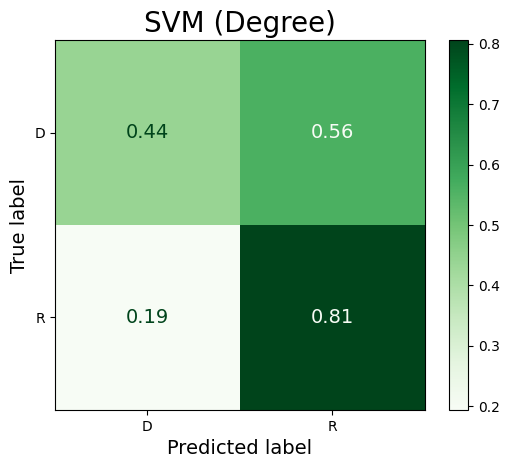

In [16]:
# Plotting confusion matrix
mat = ConfusionMatrixDisplay.from_estimator(grid_degree, X_test, y_test, cmap = 'Greens', normalize = 'true')
for text in mat.ax_.texts:
    text.set_fontsize(14)

plt.xlabel('Predicted label', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.title('SVM (Degree)', fontsize = 20)
plt.show()

In [17]:
# Baseline Logistic Regression model involving Closeness Centrality

# Define X and y
X = df[['job', 'gender', 'closeness_centrality', 'closeness_diff']]
y = df['party']

# Train/test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = 21)

# Training the model
clf_close = LogisticRegression()
clf_close.fit(X_train2, y_train2)
y_pred2 = clf_close.predict(X_test2)

# Reporting results
print(classification_report(y_test2, y_pred2))
print(confusion_matrix(y_test2, y_pred2))

              precision    recall  f1-score   support

           D       0.77      0.40      0.53        75
           R       0.56      0.87      0.68        67

    accuracy                           0.62       142
   macro avg       0.67      0.63      0.60       142
weighted avg       0.67      0.62      0.60       142

[[30 45]
 [ 9 58]]


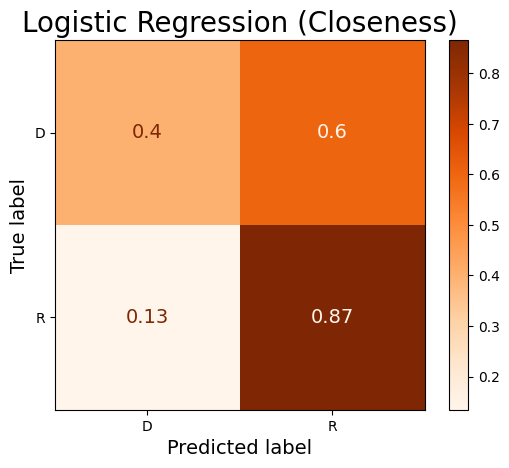

In [18]:
# Plotting confusion matrix
mat = ConfusionMatrixDisplay.from_estimator(clf_close, X_test2, y_test2, cmap = 'Oranges', normalize = 'true')
for text in mat.ax_.texts:
    text.set_fontsize(14)

plt.xlabel('Predicted label', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.title('Logistic Regression (Closeness)', fontsize = 20)
plt.show()

In [19]:
# SVM model with Closeness Centrality

# Using GridSearch to tune the SVM; training model
param_grid = {'C': [0.1,1, 10], 'gamma': [1,0.1,0.01],'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}
grid_close = GridSearchCV(svm.SVC(probability = True), param_grid, refit = True)
grid_close.fit(X_train2, y_train2)
y_pred2 = grid_close.predict(X_test2)

# Reporting results
print(f"Best Parameters: {grid_close.best_estimator_}")
print(classification_report(y_test2, y_pred2))
print(confusion_matrix(y_test2, y_pred2))

Best Parameters: SVC(C=10, gamma=1, kernel='sigmoid', probability=True)
              precision    recall  f1-score   support

           D       0.62      0.39      0.48        75
           R       0.52      0.73      0.60        67

    accuracy                           0.55       142
   macro avg       0.57      0.56      0.54       142
weighted avg       0.57      0.55      0.54       142

[[29 46]
 [18 49]]


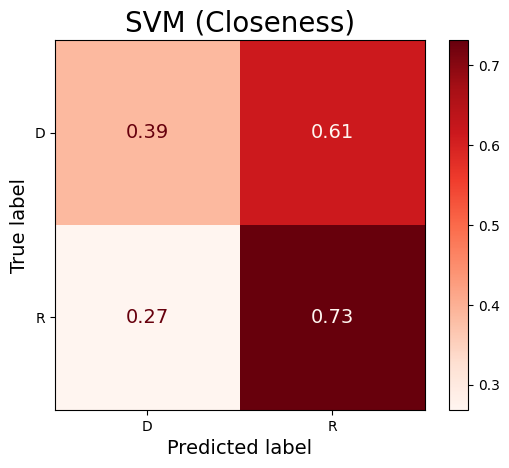

In [20]:
# Plotting confusion matrix
mat = ConfusionMatrixDisplay.from_estimator(grid_close, X_test2, y_test2, cmap = 'Reds', normalize = 'true')
for text in mat.ax_.texts:
    text.set_fontsize(14)

plt.xlabel('Predicted label', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.title('SVM (Closeness)', fontsize = 20)
plt.show()

In [32]:
models = {
    "LogReg (degree)": clf_degree,
    "LogReg (closeness)": clf_close,
    "SVM (degree)": grid_degree,
    "SVM (closeness)": grid_close,
}

In [33]:
X_tests = {
    "LogReg (degree)": X_test,
    "LogReg (closeness)": X_test2,
    "SVM (degree)": X_test,
    "SVM (closeness)": X_test2,
}

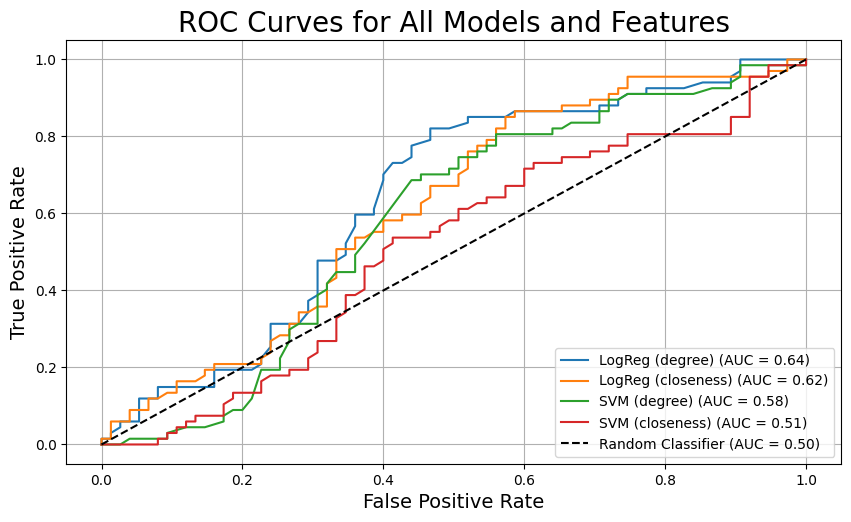

In [21]:
# Printing out ROC curves for all models

# Listing model names
models = {
    "LogReg (degree)": clf_degree,
    "LogReg (closeness)": clf_close,
    "SVM (degree)": grid_degree,
    "SVM (closeness)": grid_close,
}

# Listing respective X_test sets
X_tests = {
    "LogReg (degree)": X_test,
    "LogReg (closeness)": X_test2,
    "SVM (degree)": X_test,
    "SVM (closeness)": X_test2,
}

# Encoding response variable
encoder = LabelEncoder()
y_test = encoder.fit_transform(y_test)

# Getting values for ROC curves
plt.figure(figsize=(10, 5.5))
for name, model in models.items():
    X_test = X_tests[name]

    # Getting probabilities
    if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    # Getting true positive and false positive rates
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f"{name} (AUC = {roc_auc:.2f})")

# Plotting ROC curves
plt.plot([0, 1], [0, 1], "k--", label = "Random Classifier (AUC = 0.50)")
plt.xlabel("False Positive Rate", fontsize = 14)
plt.ylabel("True Positive Rate", fontsize = 14)
plt.title("ROC Curves for All Models and Features", fontsize = 20)
plt.legend(loc = "lower right")
plt.grid(True)
plt.show()